In [186]:
import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import pickle
from random import shuffle
from scipy.misc import imread
from scipy.misc import imresize
import tensorflow as tf

from ssd import SSD300
from ssd_training import MultiboxLoss
from ssd_utils import BBoxUtility

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(suppress=True)

# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.9
# set_session(tf.Session(config=config))

In [187]:
# some constants
NUM_CLASSES = 2
input_shape = (300, 300, 3)

In [188]:
priors = pickle.load(open('prior_boxes_ssd300.pkl', 'rb'))
bbox_util = BBoxUtility(NUM_CLASSES, priors)

In [189]:
train_annotation_path = '/home/mx/qingyang/data/aiator_data/ssd_train.txt'
val_annotation_path = '/home/mx/qingyang/data/aiator_data/ssd_val.txt'

with open(train_annotation_path) as f_train:
    lines_train = f_train.readlines()
with open(val_annotation_path) as f_val:
    lines_val = f_val.readlines()
num_val = len(lines_val)
num_train = len(lines_train)
gt_train={}
gt_val={}
for i in range(num_train):
    line = lines_train[i].split()
    gt_train[line[0]] = np.asarray([np.asarray(list(map(float,box.split(',')))) for box in line[1:]])
    # set last as 1
    h,w = imread(line[0]).shape
    gt_train[line[0]][0][0] /= w
    gt_train[line[0]][0][1] /= h
    gt_train[line[0]][0][2] /= w
    gt_train[line[0]][0][3] /= h
    gt_train[line[0]][0][-1] = 1
    
    gt_train[line[0]][1][0] /= w
    gt_train[line[0]][1][1] /= h
    gt_train[line[0]][1][2] /= w
    gt_train[line[0]][1][3] /= h
    gt_train[line[0]][1][-1] = 1
for i in range(num_val):
    line = lines_val[i].split()
    gt_val[line[0]] = np.asarray([np.asarray(list(map(float,box.split(',')))) for box in line[1:]])
    # set last as 1
    h,w = imread(line[0]).shape
    gt_val[line[0]][0][0] /= w
    gt_val[line[0]][0][1] /= h
    gt_val[line[0]][0][2] /= w
    gt_val[line[0]][0][3] /= h
    gt_val[line[0]][0][-1] = 1
    
    gt_val[line[0]][1][0] /= w
    gt_val[line[0]][1][1] /= h
    gt_val[line[0]][1][2] /= w
    gt_val[line[0]][1][3] /= h    
    gt_val[line[0]][1][-1] = 1
train_keys = list(gt_train.keys())
val_keys = list(gt_val.keys())


gt = {**gt_train, **gt_val}


# gt = pickle.load(open('gt_pascal.pkl', 'rb'))
# keys = sorted(gt.keys())
# num_train = int(round(0.8 * len(keys)))
# train_keys = keys[:num_train]
# val_keys = keys[num_train:]
# num_val = len(val_keys)

/home/mx/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  app.launch_new_instance()
/home/mx/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


In [190]:
class Generator(object):
    def __init__(self, gt, bbox_util,
                 batch_size, path_prefix,
                 train_keys, val_keys, image_size,
                 saturation_var=0.5,
                 brightness_var=0.5,
                 contrast_var=0.5,
                 lighting_std=0.5,
                 hflip_prob=0.5,
                 vflip_prob=0.5,
                 do_crop=True,
                 crop_area_range=[0.75, 1.0],
                 aspect_ratio_range=[3./4., 4./3.]):
        self.gt = gt
        self.bbox_util = bbox_util
        self.batch_size = batch_size
        self.path_prefix = path_prefix
        self.train_keys = train_keys
        self.val_keys = val_keys
        self.train_batches = len(train_keys)
        self.val_batches = len(val_keys)
        self.image_size = image_size
        self.color_jitter = []
        if saturation_var:
            self.saturation_var = saturation_var
            self.color_jitter.append(self.saturation)
        if brightness_var:
            self.brightness_var = brightness_var
            self.color_jitter.append(self.brightness)
        if contrast_var:
            self.contrast_var = contrast_var
            self.color_jitter.append(self.contrast)
        self.lighting_std = lighting_std
        self.hflip_prob = hflip_prob
        self.vflip_prob = vflip_prob
        self.do_crop = do_crop
        self.crop_area_range = crop_area_range
        self.aspect_ratio_range = aspect_ratio_range
        
    def grayscale(self, rgb):
#         return rgb.dot([1, 1, 1])
        return rgb.dot([0.299, 0.587, 0.114])

    def saturation(self, rgb):
        gs = self.grayscale(rgb)
        alpha = 2 * np.random.random() * self.saturation_var 
        alpha += 1 - self.saturation_var
        rgb = rgb * alpha + (1 - alpha) * gs[:, :, None]
        return np.clip(rgb, 0, 255)

    def brightness(self, rgb):
        alpha = 2 * np.random.random() * self.brightness_var 
        alpha += 1 - self.saturation_var
        rgb = rgb * alpha
        return np.clip(rgb, 0, 255)

    def contrast(self, rgb):
        gs = self.grayscale(rgb).mean() * np.ones_like(rgb)
        alpha = 2 * np.random.random() * self.contrast_var 
        alpha += 1 - self.contrast_var
        rgb = rgb * alpha + (1 - alpha) * gs
        return np.clip(rgb, 0, 255)

    def lighting(self, img):
        cov = np.cov(img.reshape(-1, 3) / 255.0, rowvar=False)
        eigval, eigvec = np.linalg.eigh(cov)
        noise = np.random.randn(3) * self.lighting_std
        noise = eigvec.dot(eigval * noise) * 255
        img += noise
        return np.clip(img, 0, 255)
    
    def horizontal_flip(self, img, y):
        if np.random.random() < self.hflip_prob:
            img = img[:, ::-1]
            y[:, [0, 2]] = 1 - y[:, [2, 0]]
        return img, y
    
    def vertical_flip(self, img, y):
        if np.random.random() < self.vflip_prob:
            img = img[::-1]
            y[:, [1, 3]] = 1 - y[:, [3, 1]]
        return img, y
    
    def random_sized_crop(self, img, targets):
        img_w = img.shape[1]
        img_h = img.shape[0]
        img_area = img_w * img_h
        random_scale = np.random.random()
        random_scale *= (self.crop_area_range[1] -
                         self.crop_area_range[0])
        random_scale += self.crop_area_range[0]
        target_area = random_scale * img_area
        random_ratio = np.random.random()
        random_ratio *= (self.aspect_ratio_range[1] -
                         self.aspect_ratio_range[0])
        random_ratio += self.aspect_ratio_range[0]
        w = np.round(np.sqrt(target_area * random_ratio))     
        h = np.round(np.sqrt(target_area / random_ratio))
        if np.random.random() < 0.5:
            w, h = h, w
        w = min(w, img_w)
        w_rel = w / img_w
        w = int(w)
        h = min(h, img_h)
        h_rel = h / img_h
        h = int(h)
        x = np.random.random() * (img_w - w)
        x_rel = x / img_w
        x = int(x)
        y = np.random.random() * (img_h - h)
        y_rel = y / img_h
        y = int(y)
        img = img[y:y+h, x:x+w]
        new_targets = []
        for box in targets:
            cx = 0.5 * (box[0] + box[2])
            cy = 0.5 * (box[1] + box[3])
            if (x_rel < cx < x_rel + w_rel and
                y_rel < cy < y_rel + h_rel):
                xmin = (box[0] - x_rel) / w_rel
                ymin = (box[1] - y_rel) / h_rel
                xmax = (box[2] - x_rel) / w_rel
                ymax = (box[3] - y_rel) / h_rel
                xmin = max(0, xmin)
                ymin = max(0, ymin)
                xmax = min(1, xmax)
                ymax = min(1, ymax)
                box[:4] = [xmin, ymin, xmax, ymax]
                new_targets.append(box)
        new_targets = np.asarray(new_targets).reshape(-1, targets.shape[1])
        return img, new_targets
    
    def generate(self, train=True):
        
        while True:
            if train:
                shuffle(self.train_keys)
                keys = self.train_keys
            else:
                shuffle(self.val_keys)
                keys = self.val_keys
            inputs = []
            targets = []
            for key in keys:            
                img_path = self.path_prefix + key
                
                img = imread(img_path).astype('float32')
                img = np.asarray([img]*3).transpose(1,2,0)

                y = self.gt[key].copy()
                if train and self.do_crop:
                    img, y = self.random_sized_crop(img, y)
                img = imresize(img, self.image_size).astype('float32')
                if train:
                    shuffle(self.color_jitter)
                    for jitter in self.color_jitter:
                        img = jitter(img)
                    if self.lighting_std:
                        img = self.lighting(img)
                    if self.hflip_prob > 0:
                        img, y = self.horizontal_flip(img, y)
                    if self.vflip_prob > 0:
                        img, y = self.vertical_flip(img, y)
                y = self.bbox_util.assign_boxes(y)
                inputs.append(img)                
                targets.append(y)
                if len(targets) == self.batch_size:
                    tmp_inp = np.array(inputs)
                    tmp_targets = np.array(targets)
                    inputs = []
                    targets = []
                    yield preprocess_input(tmp_inp,mode='tf'), tmp_targets

In [191]:
path_prefix = ''
gen = Generator(gt, bbox_util, 16, '',
                train_keys, val_keys,
                (input_shape[0], input_shape[1]), do_crop=False)

In [192]:
model = SSD300(input_shape, num_classes=NUM_CLASSES)
model.load_weights('/home/mx/qingyang/working/aiator_ssd/logs000/weights.01-0.77.hdf5', by_name=True)

/home/mx/qingyang/working/aiator_ssd/ssd.py:40: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="conv1_1", padding="same")`
  name='conv1_1')(net['input'])
/home/mx/qingyang/working/aiator_ssd/ssd.py:44: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="conv1_2", padding="same")`
  name='conv1_2')(net['conv1_1'])
/home/mx/qingyang/working/aiator_ssd/ssd.py:46: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D((2, 2), strides=(2, 2), name="pool1", padding="same")`
  name='pool1')(net['conv1_2'])
/home/mx/qingyang/working/aiator_ssd/ssd.py:51: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="conv2_1", padding="same")`
  name='conv2_1')(net['pool1'])
/home/mx/qingyang/working/aiator_ssd/ssd.py:55: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", nam

In [8]:
freeze = ['input_1', 'conv1_1', 'conv1_2', 'pool1',
          'conv2_1', 'conv2_2', 'pool2',
          'conv3_1', 'conv3_2', 'conv3_3', 'pool3']#,
#           'conv4_1', 'conv4_2', 'conv4_3', 'pool4']

for L in model.layers:
    if L.name in freeze:
        L.trainable = False

In [9]:
def schedule(epoch, decay=0.9):
    return base_lr * decay**(epoch)

callbacks = [keras.callbacks.ModelCheckpoint('/home/mx/qingyang/working/aiator_ssd/logs000/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
                                             verbose=1,
                                             save_weights_only=True),
             keras.callbacks.LearningRateScheduler(schedule)]

In [10]:
base_lr = 3e-4
optim = keras.optimizers.Adam(lr=base_lr)
# optim = keras.optimizers.RMSprop(lr=base_lr)
# optim = keras.optimizers.SGD(lr=base_lr, momentum=0.9, decay=decay, nesterov=True)
model.compile(optimizer=optim,
              loss=MultiboxLoss(NUM_CLASSES, neg_pos_ratio=2.0).compute_loss)

In [11]:
nb_epoch = 30
history = model.fit_generator(gen.generate(True), gen.train_batches,
                              nb_epoch, verbose=1,
                              callbacks=callbacks,
                              validation_data=gen.generate(False),
                              nb_val_samples=gen.val_batches,
                              nb_worker=1)

/home/mx/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  import sys
/home/mx/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., 188, 30, verbose=1, callbacks=[<keras.ca..., validation_data=<generator..., validation_steps=20, workers=1)`
  import sys
/home/mx/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.


Epoch 1/30
188/188 [==============================] - 340s 2s/step - loss: 0.9114 - val_loss: 0.7664

Epoch 00001: saving model to /home/mx/qingyang/working/aiator_ssd/logs000/weights.01-0.77.hdf5
Epoch 2/30
188/188 [==============================] - 321s 2s/step - loss: 0.2602 - val_loss: 1.1838

Epoch 00002: saving model to /home/mx/qingyang/working/aiator_ssd/logs000/weights.02-1.18.hdf5
Epoch 3/30
188/188 [==============================] - 334s 2s/step - loss: 0.0894 - val_loss: 1.1614

Epoch 00003: saving model to /home/mx/qingyang/working/aiator_ssd/logs000/weights.03-1.16.hdf5
Epoch 4/30
188/188 [==============================] - 334s 2s/step - loss: 0.0493 - val_loss: 1.2590

Epoch 00004: saving model to /home/mx/qingyang/working/aiator_ssd/logs000/weights.04-1.26.hdf5
Epoch 5/30
188/188 [==============================] - 332s 2s/step - loss: 0.0290 - val_loss: 1.1661

Epoch 00005: saving model to /home/mx/qingyang/working/aiator_ssd/logs000/weights.05-1.17.hdf5
Epoch 6/30
 18/

KeyboardInterrupt: 

1/1 [==============================] - 0s 18ms/step


/home/mx/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


1/1 [==============================] - 0s 14ms/step


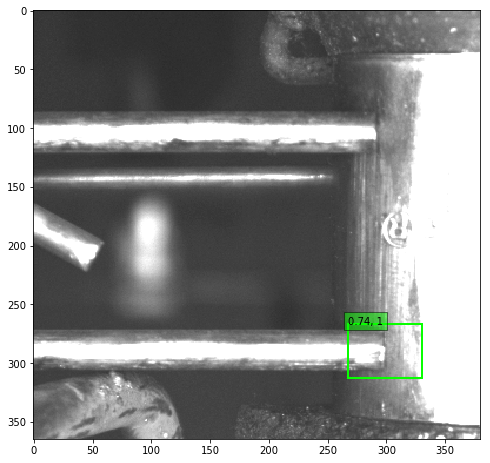

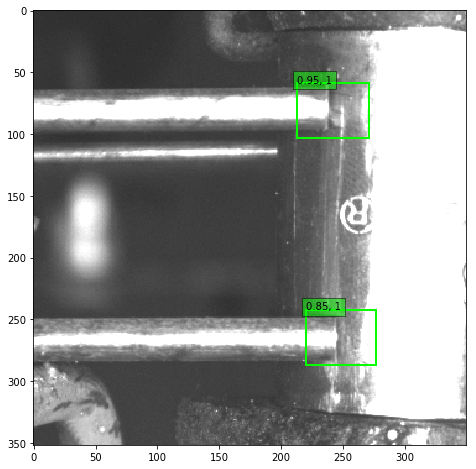

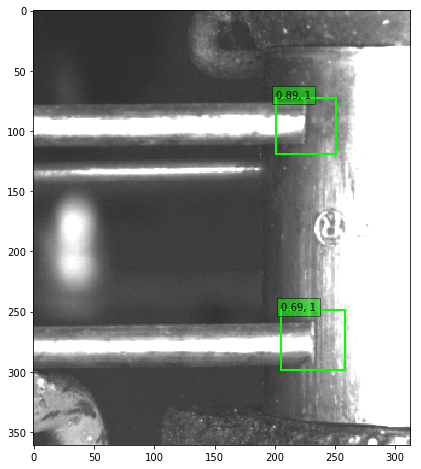

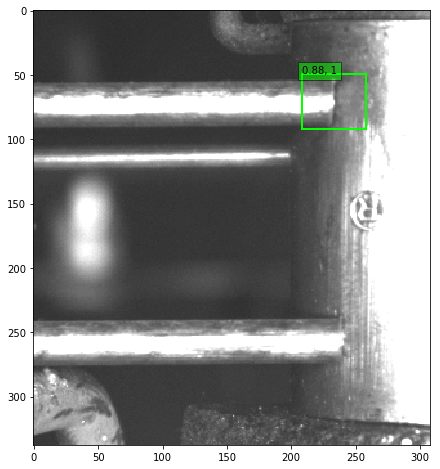

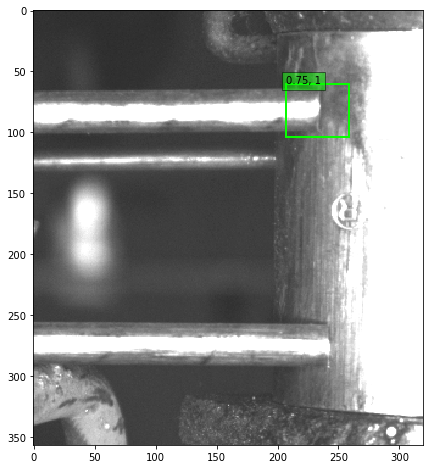

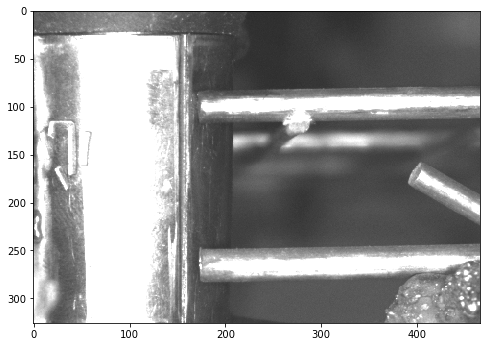

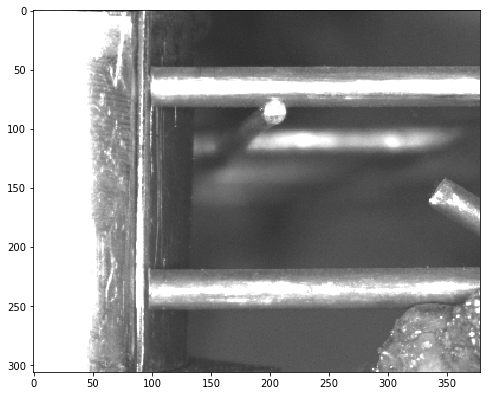

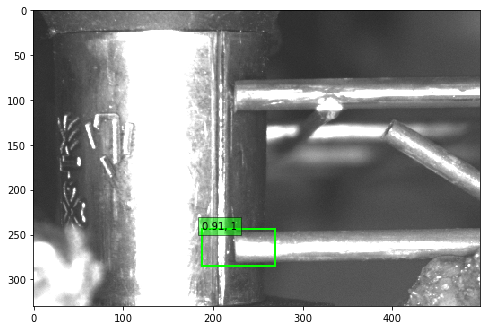

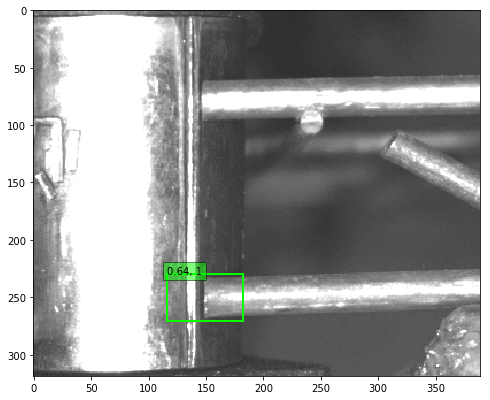

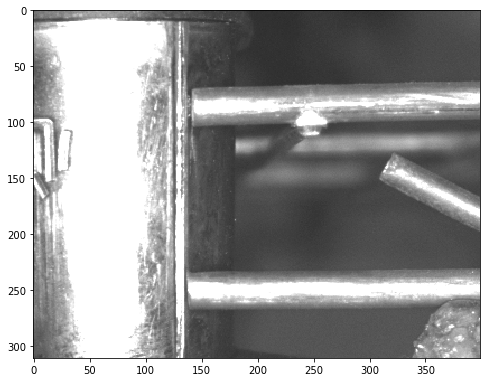

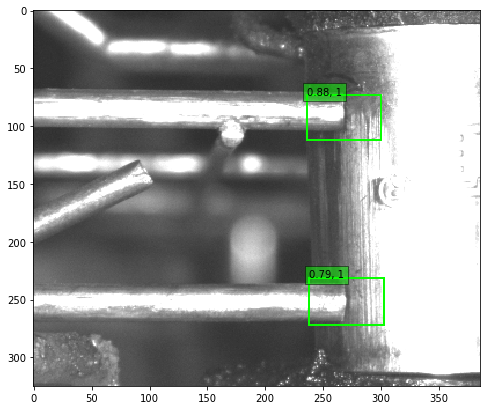

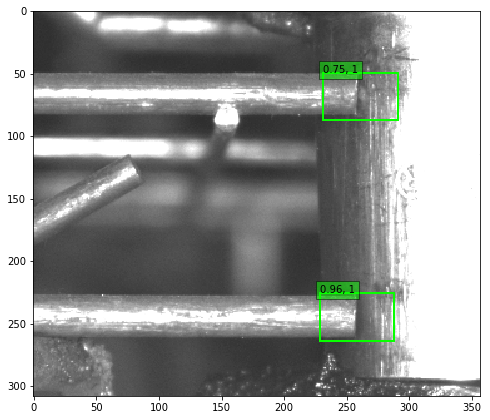

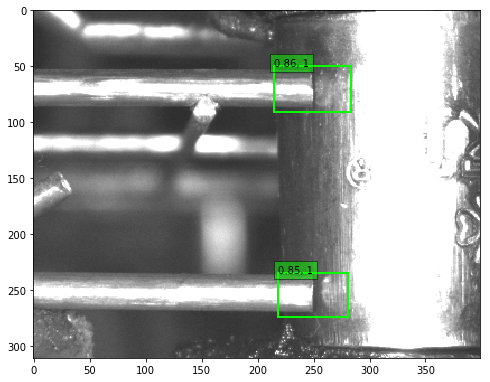

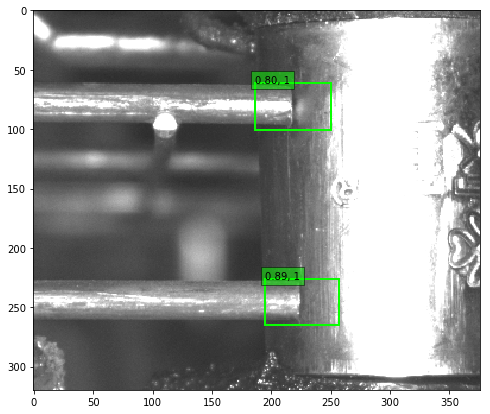

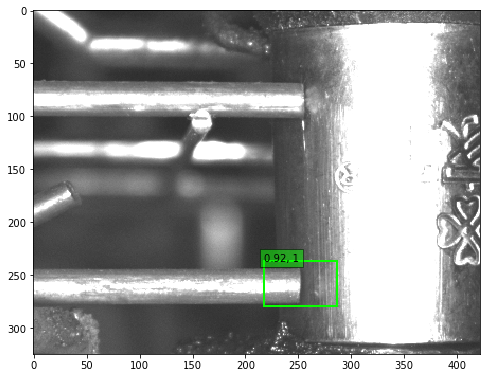

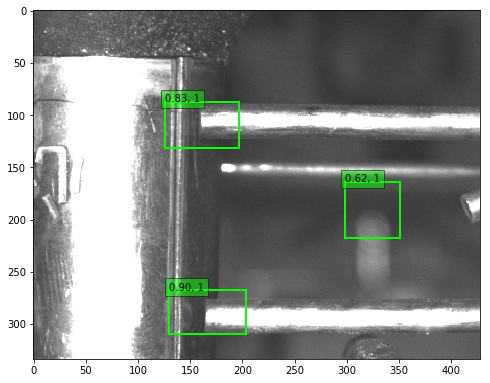

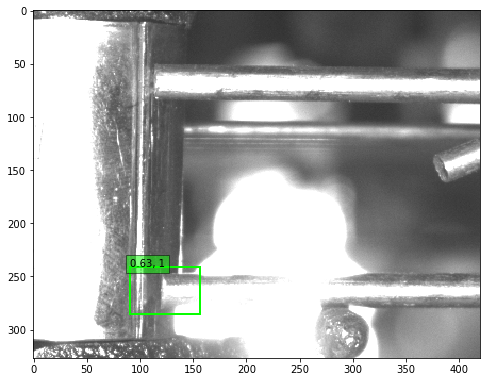

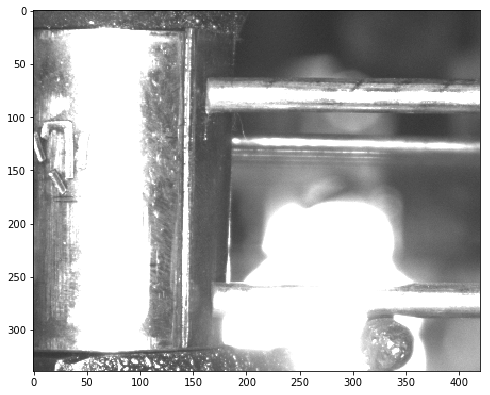

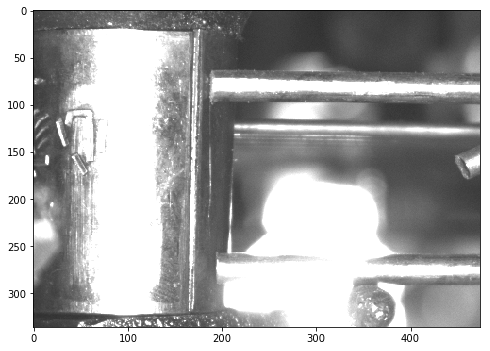

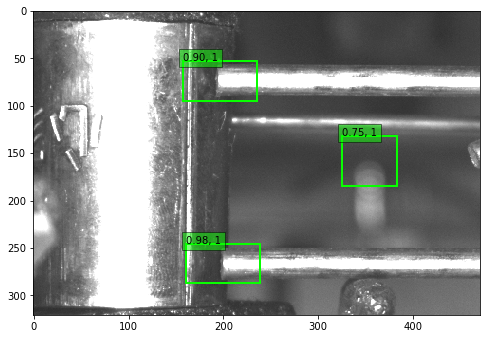

In [194]:
for j in range(1,21):
    inputs = []
    images = []
    img_path = '/home/mx/qingyang/data/huizhou_3/'+str(j)+'.bmp'
    img = image.load_img(img_path, target_size=(300, 300))
    img = image.img_to_array(img)
    images.append(imread(img_path))
    inputs.append(img.copy())

    inputs = preprocess_input(np.array(inputs),mode='tf')
    inputs = np.array(inputs)

    preds = model.predict(inputs, batch_size=20, verbose=1)
    results = bbox_util.detection_out(preds)
    plt.figure()
    for i, img in enumerate(images):
        # Parse the outputs.
        det_label = results[i][:, 0]
        det_conf = results[i][:, 1]
        det_xmin = results[i][:, 2]
        det_ymin = results[i][:, 3]
        det_xmax = results[i][:, 4]
        det_ymax = results[i][:, 5]

        # Get detections with confidence higher than 0.6.
        top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]

        top_conf = det_conf[top_indices]
        top_label_indices = det_label[top_indices].tolist()
        top_xmin = det_xmin[top_indices]
        top_ymin = det_ymin[top_indices]
        top_xmax = det_xmax[top_indices]
        top_ymax = det_ymax[top_indices]

        colors = plt.cm.hsv(np.linspace(0, 1, 4)).tolist()

        plt.imshow(img / 255.,cmap='gray')
        currentAxis = plt.gca()

        for i in range(top_conf.shape[0]):
            xmin = int(round(top_xmin[i] * img.shape[1]))
            ymin = int(round(top_ymin[i] * img.shape[0]))
            xmax = int(round(top_xmax[i] * img.shape[1]))
            ymax = int(round(top_ymax[i] * img.shape[0]))
            score = top_conf[i]
            label = int(top_label_indices[i])
    #         label_name = voc_classes[label - 1]
            display_txt = '{:0.2f}, {}'.format(score, label)
            coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
            color = colors[label]
            currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
            currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})

    plt.savefig('results_huizhou_'+str(j))

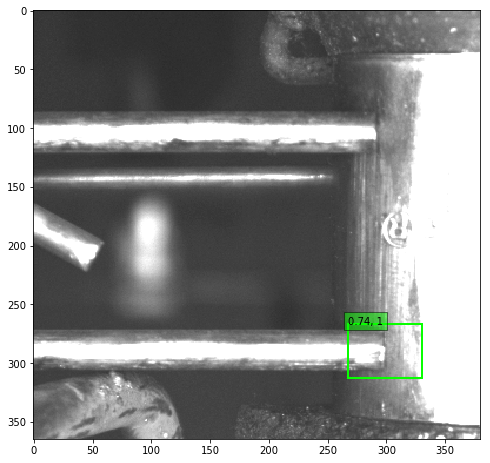

1